# DIFUSIÓN DEL CORONAVIRUS EN ESPAÑA:

## (4ª predicción: pesos reajustados, sobre modelo de orden 2)

## 0. INTRODUCCIÓN

Si se quieren ver directamente los resultados de los cálculos, y el pronóstico para los próximos 5 días, pinchar <a href='#a1'>**--> aquí**</a>.

Este es un pequeño ejercicio de extrapolación para la curva de contagios del coronavirus en España.

Como fuente de los datos, a falta de una mejor, se toman los volcados en la siguiente página:

https://www.rtve.es/noticias/20200316/mapa-del-coronavirus-espana/2004681.shtml

Que recoge los datos que vuelca el Ministerio de Sanidad español. La hora de los contagios en el día de dicho informe puede variar, por lo que la diferencia entre un día y otro puede ser mayor o menor de 24 horas, pero a priori se asumirá que la hora del informe de todos los días es la misma, por falta de referencias.

El modelo que emplearemos no será más que una sencilla aproximación por una exponencial, no se empleará el modelo SIR como primera aproximación, aunque este es sólo ligeramente más complejo.

Un modelo de contagio (no asumiendo que cada persona ya contagiada no podría volver a ser contagiada, o asumiendo que la fracción de la población contagiada aún es lo suficientemente baja como para despreciar dichos efectos, lo que es válido para el comienzo de la progresión de la pandemia) respondería a una ecuación diferencial del estilo de:

$y' = c y$

Cuya solución es de la forma:

$ y = K e^{c x}$

O, lo que es lo mismo:

$ y = H A^{b x}$

Donde, para que ambas expresiones sean la misma, tendremos que:

$b = \frac{K}{H \cdot ln(A)} c$

Por lo tanto, tomando logaritmos tendremos:

$ ln(y) = c x + K = b \cdot ln(A) x + H$

En donde tendremos ya una relación lineal.

Nuestro enfoque, por lo tanto, será el de calcular los coeficientes de esta recta.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
ruta = 'Datos/Contagios medios coronavirus RTVE.csv'
sep = ';'

date_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

datos = pd.read_csv(ruta, sep = sep, index_col = 'FECHA', parse_dates = ['FECHA'], date_parser = date_parser)

datos.head()

,CONTAGIOS,MUERTOS
FECHA,,
2020-02-12,2,0
2020-02-25,3,0
2020-02-26,7,0
2020-02-27,16,0
2020-02-28,31,0


In [3]:
datos['DIFER_DIAS'] = datos.index.to_series().diff().fillna(pd.Timedelta(seconds = 8660000)).apply(lambda x: x.days)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


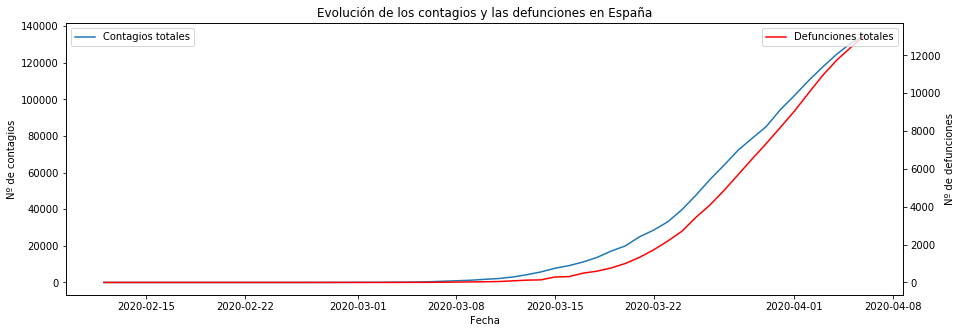

In [4]:
contagios = pd.DataFrame(datos[['CONTAGIOS', 'DIFER_DIAS']])
muertos = pd.DataFrame(datos[['MUERTOS', 'DIFER_DIAS']])

fig, ax1 = plt.subplots(figsize=(15,5))

plt.title('Evolución de los contagios y las defunciones en España')

ax1.plot(contagios.reset_index()['FECHA'], contagios['CONTAGIOS'], '-');
ax1.legend(['Contagios totales'])
ax1.set_ylabel("Nº de contagios")
ax1.set_xlabel("Fecha")

ax2 = ax1.twinx()

ax2.plot(muertos.reset_index()['FECHA'], muertos['MUERTOS'], '-', color='r')
ax2.legend(['Defunciones totales'], loc = 1)
ax2.set_ylabel("Nº de defunciones");

Comparación entre la evolución de los contagios y los muertos, donde puede obsservarse el comportamiento comparado de ambas gráficas, y el retardo existente entre la evolución de los muertos por la infección y el número de infectados:

Nótese cómo la pendiente de la gráfica de la evolución del número de muertos es mucho más empinada que la del número de contagiados.

Queremos analizar ahora el decalaje existente entre ambas series. Para ello emplearemos dos métodos:

En el primero haremos lo más evidente, que sería buscar, para cada día de la serie de los contagios, el día con un valor equivalente en la serie de defunciones y calcularemos su diferencia.

Para encontrar dicho día equivalente lo que haremos es buscar, por un lado, el primer día de la serie de defunciones cuyo valor es superior al buscado, y por otro, el último día que es inferior, y tomaremos la media de ambos valores (debido que en algunos casos la diferencia entre ambos valores es relativamente elevada):

In [5]:
storage = np.array([])

for element in contagios.iterrows():

    try:
        
       for_mean = (muertos[muertos['MUERTOS'] > element[1][0]].index[0] - element[0]).days
       for_mean += (muertos[muertos['MUERTOS'] < element[1][0]].index[-1] - element[0]).days
        
       storage = np.append(storage, for_mean/2)
        
    except IndexError:
        continue
        
storage.mean()

12.527777777777779

Podemos observar que el valor obtenido para el decalaje es de unos 12,5 días.

Vamos a contrastar esto con un segundo método:
    
En este segundo método lo que haremos será desplazar la serie de contagios 1, 2, 3, ... n días (hasta 16) y comparar la diferencia relativa de ambas curvas, mediante un error absoluto medio.

El desplazamiento que obtenga menor diferencia relativa será el que mejor coloque la curva de decesos sobre la de contagios:

In [81]:
# Creamos un índice completo para nuestras fechas de interés:

index_for_merge = pd.DataFrame(index = pd.date_range(pd.to_datetime('2020-02-12', format = '%Y-%m-%d'), pd.to_datetime('2020-04-06', format = '%Y-%m-%d')))

# Creamos un dataframe con todas las fechas para ambas series, y rellenamos los NaN con el último dato inmediatamente anterior:

contagios_full_index = pd.merge(index_for_merge, contagios, left_index= True, right_index= True, how='left') 
contagios_full_index.fillna(method = 'ffill', inplace = True)

muertos_full_index = pd.merge(index_for_merge, muertos, left_index= True, right_index= True, how='left') 
muertos_full_index.fillna(method = 'ffill', inplace = True)

# Calculamos la diferencia relativa entre ambas curvas:

for x in range(1,16):

    print(x, " días de decalaje, error: ", 
          (abs(contagios_full_index['CONTAGIOS'] - muertos_full_index['MUERTOS'].shift(-x))/
              (contagios_full_index['CONTAGIOS'] + muertos_full_index['MUERTOS'].shift(-x))).mean())

1  días de decalaje, error:  0.9262636417204129
2  días de decalaje, error:  0.9105206380360908
3  días de decalaje, error:  0.889405098907615
4  días de decalaje, error:  0.8607702373341347
5  días de decalaje, error:  0.8259435423970468
6  días de decalaje, error:  0.7818852731835038
7  días de decalaje, error:  0.7161899422681874
8  días de decalaje, error:  0.6351700871861351
9  días de decalaje, error:  0.5485105902022819
10  días de decalaje, error:  0.49416402973784873
11  días de decalaje, error:  0.463962038575954
12  días de decalaje, error:  0.4691874177108114
13  días de decalaje, error:  0.4947169777374246
14  días de decalaje, error:  0.522498149760895
15  días de decalaje, error:  0.5513053600365126


Como podemos observar que el error relativo medio mínimo se encuentra en los 11 días, un fuerte indicador de que el decalaje entre ambas curvas es esta cantidad.

Finalmente, si representamos dicho decalaje de 11 días podemos ver cómo la curva de defunciones sigue el comportamiento de la curva de contagios casi a la perfección:

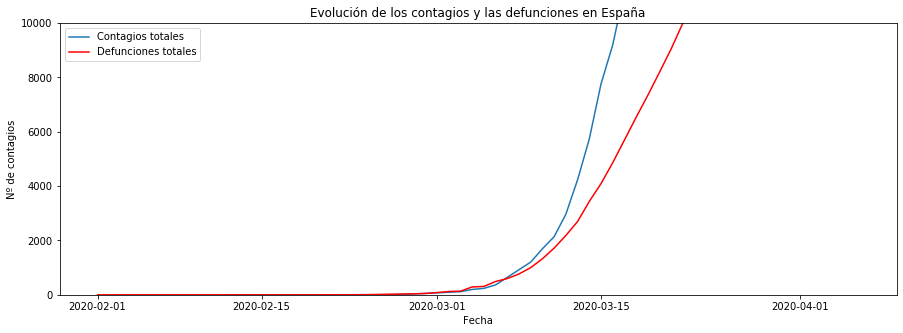

In [78]:
fig, ax1 = plt.subplots(figsize=(15,5))

plt.title('Evolución de los contagios y las defunciones en España')

ax1.set_ylim(ymax = 10000)

ax1.plot(contagios.reset_index()['FECHA'], contagios['CONTAGIOS'], '-')
ax1.plot(muertos.reset_index()['FECHA'] - datetime.timedelta(days = 11), muertos['MUERTOS'], '-', color='r')

ax1.legend(['Contagios totales', 'Defunciones totales'], loc = 2)
ax1.set_ylabel("Nº de contagios")
ax1.set_xlabel("Fecha");

## 1. CONTAGIOS

**Paso 1:**

**Comprobaciones sobre la serie:**

Examinamos primero los datos de los contagios:

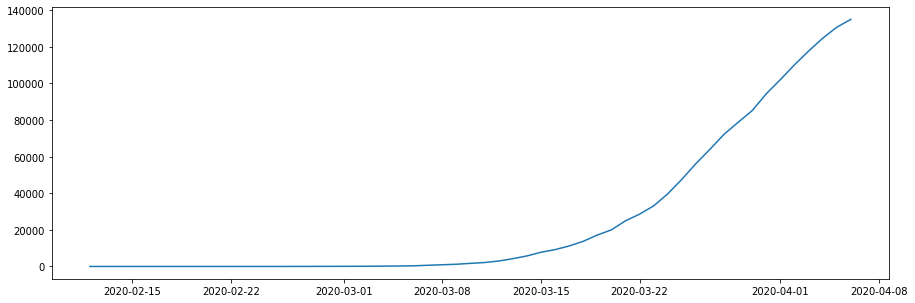

In [8]:
plt.figure(figsize=(15,5))
plt.plot(contagios.index, contagios['CONTAGIOS'], '-');

Como podemos ver, tenemos una curva monótona creciente que, aparentemente, parece seguir la forma de una exponencial.

Examinamos ahora la serie en diferencias. Como se sabe, si la serie original sigue una exponencial, la serie en diferencias debería seguir también una exponencial:

In [9]:
# Sumamos 1 por cuestiones de estabilidad numérica a la hora de tomar logaritmos posteriormente:
contagios['DIFER'] = contagios['CONTAGIOS'].diff(1).fillna(2)/contagios['DIFER_DIAS']

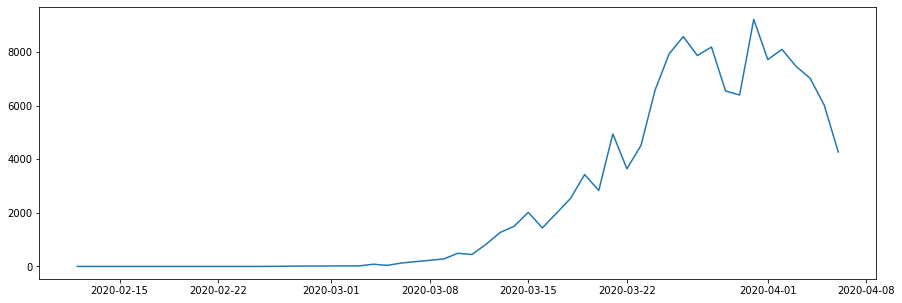

In [10]:
plt.figure(figsize=(15,5))
plt.plot(contagios['DIFER'], '-');

Vemos un primer pico en la series de los contagios, en el entorno del día 15 de marzo.

Su aparición (y tal vez la de los siguientes) puede explicarse por lo siguiente:

https://elpais.com/sociedad/2020-03-15/cataluna-y-madrid-dejan-de-hacer-pruebas-a-los-casos-leves.html

https://www.redaccionmedica.com/secciones/sanidad-hoy/coronavirus-test-solo-pacientes-hospitalizados-personal-esencial-8816

https://www.noticiasdenavarra.com/actualidad/sociedad/2020/03/16/navarra-cambia-protocolo-deteccion-coronavirus/1031165.html

https://www.elmundo.es/ciencia-y-salud/salud/2020/03/13/5e6b4230fdddff878c8b4624.html

Al cambiar los criterios con los que hacer las pruebas, se están dejando fuera, a partir del día 15, a un gran número de casos que habrían dado positivo según los criterios antiguos, pero que ahora se dejan fuera de los casos confirmados, según los nuevos.

Si la decisión se trata de criterios de economía médica, intereses políticos o una mezcla de ambas, sólo puedo dejarlo a juicio del lector.

A pesar de ello se puede ver que nada puede hacer ese cambio de criterio frente al contagio exponencial.

Para nuestro esutio tomaremos primero solamente la primera parte de la curva, donde no se ha modificado aún el criterio para la realización de las pruebas, para no adulterar la evolución.

In [11]:
contagios['LN_CONTAGIOS'] = contagios['CONTAGIOS'].apply(lambda x: np.log(x) if x>0 else 0)
# Añadimos +1 por criterios de estabilidad con el logaritmo:
contagios['LN_DIFER'] = contagios['DIFER'].apply(lambda x: np.log(x+1) if x>0 else 0)

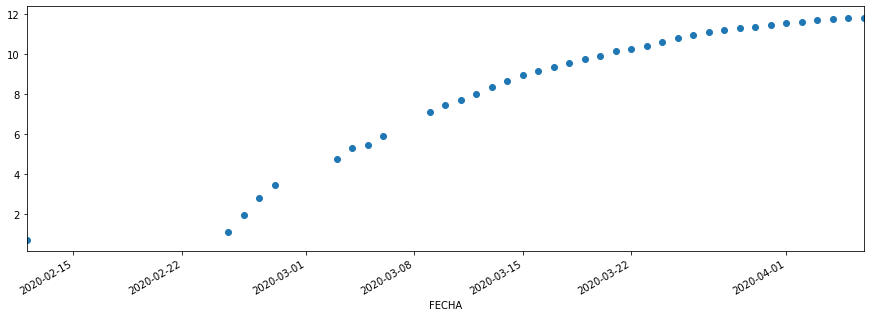

In [12]:
contagios['LN_CONTAGIOS'].plot(figsize=(15,5), style = 'o')

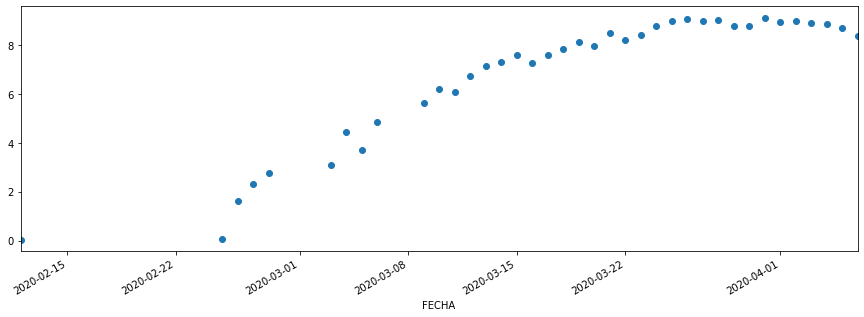

In [13]:
contagios['LN_DIFER'].plot(figsize=(15,5), style = 'o')

Como podemos ver, ante nosotros no tenemos una recta, sino más bien un comportamiento más bien parabólico, característico de funciones como una raíz cuadrada.

Esto son buenas noticias, porque nos indica que el virus no se está propagando siguiendo una exponencial, sino más bien una exponencial algo amortiguada.

También podemos observar un comportamiento errático en la serie de las diferencias de los logaritmos de los contagios diarios.

Vamos a examinar la serie de sus diferencias. Si el proceso fuese exponencial, estas deberían ser constantes:

0.19847024054383247

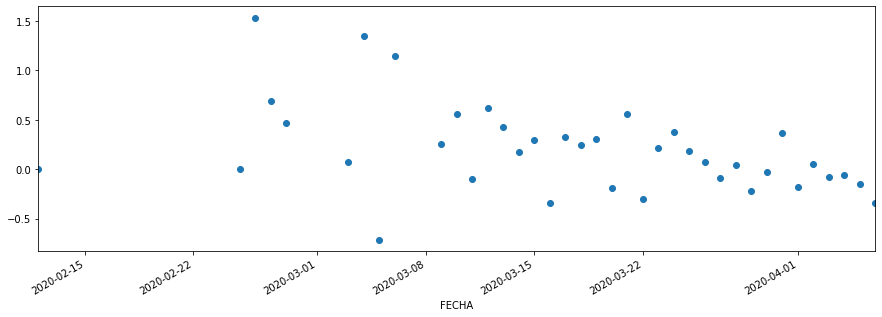

In [14]:
contagios['LN_DIFER_2']  = contagios['LN_DIFER'].diff(1).fillna(0)/contagios['DIFER_DIAS']
contagios['LN_DIFER_2'].plot(figsize=(15,5), style = 'o')
contagios['LN_DIFER_2'].mean()

Podemos observar un comportamiento claramente errático, con una varianza elevada y valores oscilando alrededor de una zona central, pero con una amplia dispersión.

También podemos observar un comportamiento decreciente.

Esto puede deberse a muchos factores relacionados con la toma de datos, con el hecho de que las horas de los informes emitidos por el Ministerio de Sanidad no siempre coincidan y con que la afluencia de la gente a hacerse las pruebas, así como los criterios para hacer las mismas han ido evolucionando según progresaba la enfermedad.

(array([ 2., 13., 14.,  6.,  1.,  2.]),
 array([-0.71724473, -0.34181562,  0.03361349,  0.4090426 ,  0.78447172,
         1.15990083,  1.53532994]),
 <a list of 6 Patch objects>)

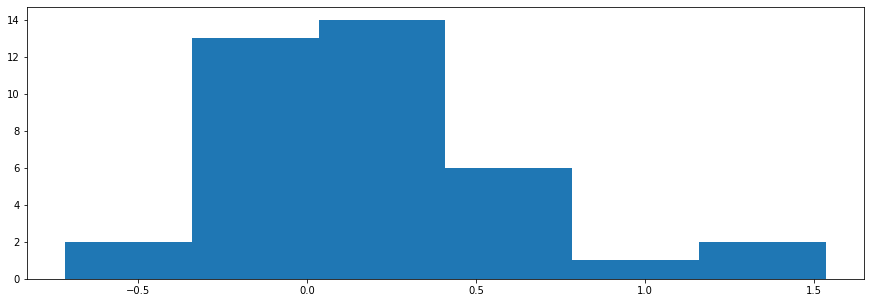

In [15]:
plt.figure(figsize=(15,5))
plt.hist(contagios['LN_DIFER_2'], bins = 6)

Como vemos, el máximo central se presenta, con 8 valores, para la zona entre 0,04 y 0,784.

In [16]:
contagios['LN_CONTAGIOS_DIFER'] = contagios['LN_CONTAGIOS'].diff(1).fillna(0)/contagios['DIFER_DIAS']

### MODELOS:

In [17]:
def cols_para_calculos(df: 'DataFrame', dates_in_index = True):
    
    if dates_in_index:
        day_range = (df.index - df.index[0]).days
        df.loc[:,'FECHA'] = day_range
    else:
        df['FECHA'] =(df.index - df.index[0])
    
    return df

In [18]:
def ajuste_min_cuadrados(serie_x: 'Series', serie_y: 'Series', col: 'string'):
    
    
    # Añadimos en el polyfit unos pesos exponenciales sobre el factor de corrección, 
    # para que el modelo ajuste el peso de los errores según los que tendrían con la distribución original 
    # del valor en y, y no la propia recta:
    
    x_range = serie_x
    coefs = np.polyfit(np.array(x_range), np.array(serie_y) , deg = 2, w=(np.exp(serie_y)/serie_y)**0.5)

    arr_pred =  x_range**2 * coefs[0] + x_range * coefs[1] + coefs[2]

    df_pred = pd.DataFrame(arr_pred)
    df_pred.rename({'FECHA':'PRED'}, axis=1, inplace = True)
    df_pred['SERIE'] = serie_y
    
    
    df_pred.plot(figsize=(18,5))
    print(df_pred.corr())
    
    df_pred[col] = np.round(np.exp(df_pred['PRED']).fillna(1))

    return df_pred, coefs

In [19]:
def prediccion(day_num_of_reference, date_of_reference, coeficientes, entre=(1,6)):    

    x_range_ext = np.array(range(day_num_of_reference + entre[0], day_num_of_reference + entre[1]))
    index = [date_of_reference + datetime.timedelta(int(x)) for x in x_range_ext]
    arr_pred = x_range_ext**2 * coeficientes[0] + x_range_ext * coeficientes[1] + coeficientes[2]

    arr_pred = np.round(np.exp(arr_pred))
    arr_pred = pd.DataFrame(arr_pred, columns = ['PRED'], index = index)
    return arr_pred

**2) SOBRE LA SERIE DE CONTAGIOS DIARIOS:**

Vamos por lo tanto a aplicar el mismo método a la serie de contagios diarios, y luego hacer su suma agregada para obtener los valores totales:

In [22]:
contagios.drop(contagios.index[[0]], inplace = True)
df_contagios_pred = contagios[['CONTAGIOS', 'DIFER_DIAS', 'LN_CONTAGIOS', 'DIFER', 'LN_DIFER']].copy()
df_contagios_pred = cols_para_calculos(df_contagios_pred)

day_num_of_reference = df_contagios_pred['FECHA'][-1]
date_of_reference = df_contagios_pred.index[0]

           PRED     SERIE
PRED   1.000000  0.991161
SERIE  0.991161  1.000000


,PRED
2020-04-07,4962.0
2020-04-08,4375.0
2020-04-09,3802.0
2020-04-10,3256.0
2020-04-11,2748.0


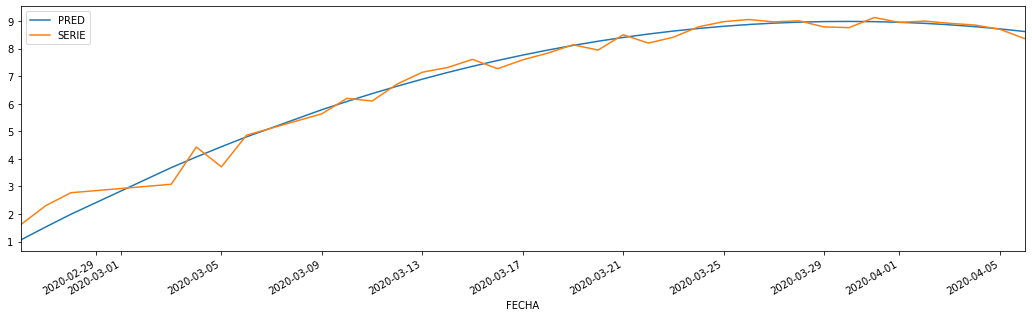

In [23]:
new_contagios_prediction_2, coefs = ajuste_min_cuadrados(df_contagios_pred['FECHA'], 
                                                       df_contagios_pred['LN_DIFER'], 
                                                       'PRED_CONT_DIARIOS')

df_contagios_pred['PRED_CONT_DIARIOS'] = new_contagios_prediction_2['PRED_CONT_DIARIOS']
df_contagios_pred['ERROR_DIFER_ABS'] = abs(df_contagios_pred['PRED_CONT_DIARIOS'] - df_contagios_pred['DIFER'])
df_contagios_pred['ERROR_DIFER_REL'] = (abs(df_contagios_pred['PRED_CONT_DIARIOS'] - df_contagios_pred['DIFER'])/df_contagios_pred['DIFER']).fillna(0)

arr_contagios_diarios_pred_2 = prediccion(day_num_of_reference, date_of_reference, coefs)
arr_contagios_diarios_pred_2

In [25]:
arr_contagios_pred_2 = arr_contagios_diarios_pred_2.cumsum() + df_contagios_pred.loc[df_contagios_pred.index[-1],'CONTAGIOS']
arr_contagios_pred_2

,PRED
2020-04-07,139994.0
2020-04-08,144369.0
2020-04-09,148171.0
2020-04-10,151427.0
2020-04-11,154175.0


Este modelo arroja resultados en la línea del anterior, pero con un comportamiento menos agresivo y un valor de pico mucho menos elevado.

Como podemos ver, la diferencia porcentual entre ambos no es muy elevada, pero sí es acumulativa, y acaba siendo para la última de las fechas a predecir, del orden de un 5%:

## 2. MUERTOS

Pasamos ahora a comprobar los de los muertos. Representamos a continuación la curva del total acumulado de muertos en España:

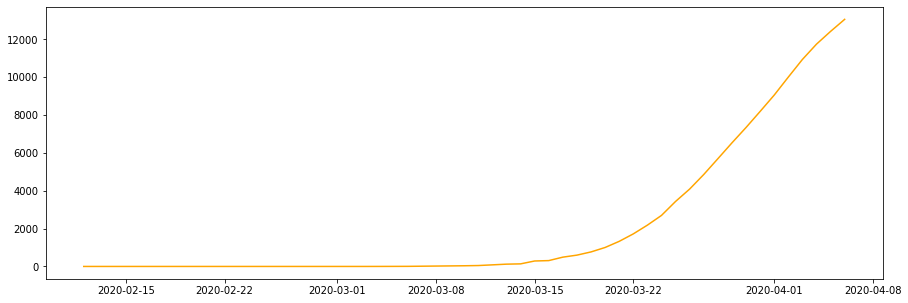

In [27]:
plt.figure(figsize=(15,5))
plt.plot(muertos['MUERTOS'], '-', color='orange');

Eliminamos, como en el caso de los contagios, el valor correspondiente al 12 de febrero:

In [28]:
muertos.drop(muertos.index[[0]], inplace = True)

A continuación, la evolución del ratio de muertos a infectados:

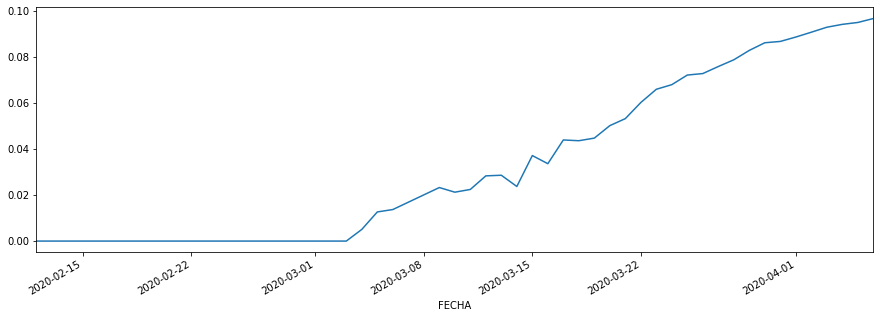

In [29]:
datos['ratio'] = datos['MUERTOS']/datos['CONTAGIOS']
datos['ratio'].plot(figsize=(15,5));

Y el ratio de muertes provocadas por la enfermedad cada día:

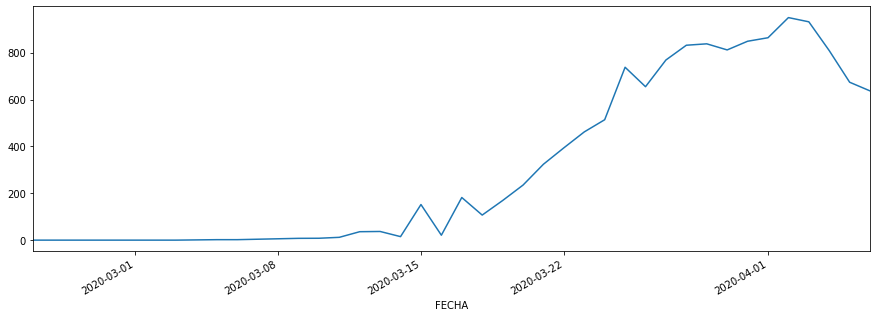

In [30]:
muertos['MUERTOS_DIARIOS'] = muertos['MUERTOS'].diff().fillna(0)/muertos['DIFER_DIAS']
muertos['MUERTOS_DIARIOS'].plot(figsize = (15,5))

Y, como en el caso de los contagios, la forma que presenta el logaritmo de las muertes acumuladas por la enfermedad, día tras día:

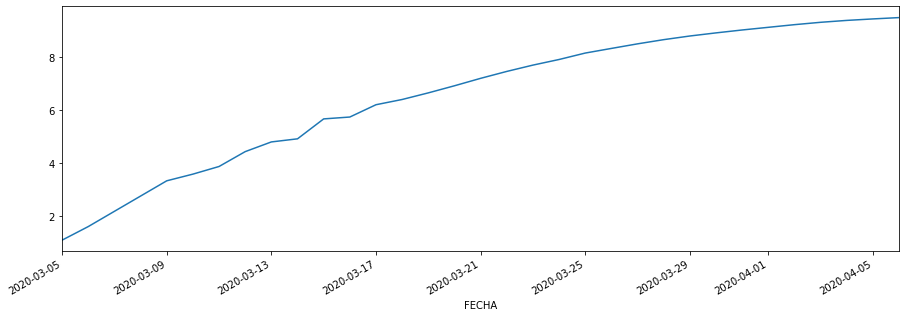

In [31]:
muertos['LN_MUERTOS'] = muertos['MUERTOS'].apply(lambda x: 0 if x == 0 else np.log(x))
muertos['LN_MUERTOS_DIARIOS'] = muertos['MUERTOS_DIARIOS'].apply(lambda x: 0 if x == 0 else np.log(x))
muertos[muertos['LN_MUERTOS'] != 0]['LN_MUERTOS'].plot(figsize=(15,5));

## MODELOS:

**2) SOBRE LA SERIE DE DEFUNCIONES DIARIAS:**

Al igual que hicimos con la serie de contagios, vamos a realizar el mismo ajuste sobre la serie de los muertos diarios:

           PRED     SERIE
PRED   1.000000  0.999224
SERIE  0.999224  1.000000


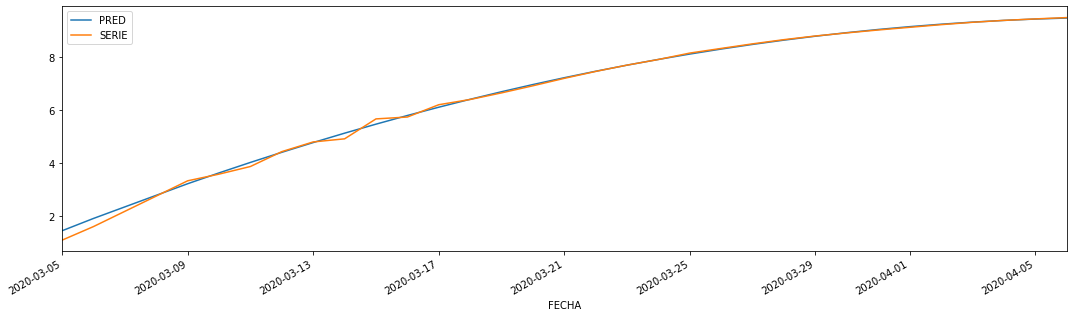

In [36]:
date_list = [muertos.index[-1] + datetime.timedelta(days=x+1) for x in range(10)]

df_muertos_pred = muertos.loc[muertos['LN_MUERTOS'] != 0, ['MUERTOS', 'DIFER_DIAS', 'LN_MUERTOS']].copy()
df_muertos_pred = cols_para_calculos(df_muertos_pred)
other_prediction, coefs = ajuste_min_cuadrados(df_muertos_pred['FECHA'], df_muertos_pred['LN_MUERTOS'], 'PRED_MUERTES')

           PRED     SERIE
PRED   1.000000  0.976491
SERIE  0.976491  1.000000


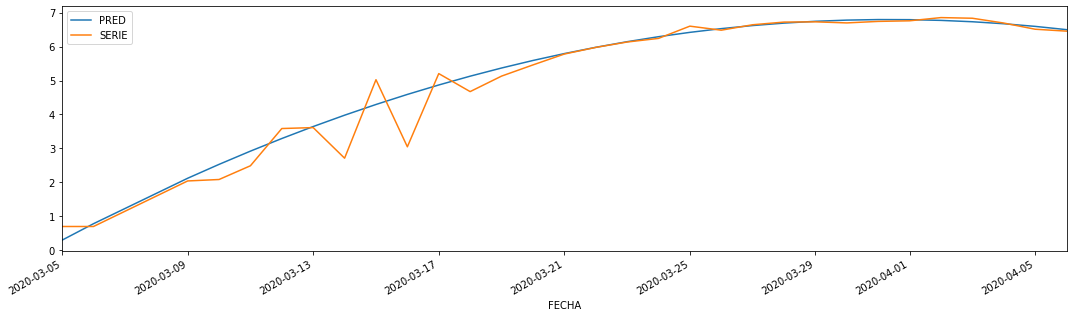

In [37]:
date_list = [muertos.index[-1] + datetime.timedelta(days=x+1) for x in range(10)]

df_muertos_diarios_pred = muertos.loc[muertos['LN_MUERTOS_DIARIOS'] != 0, 
                                      ['MUERTOS_DIARIOS', 'DIFER_DIAS', 'LN_MUERTOS_DIARIOS']].copy()

df_muertos_diarios_pred = cols_para_calculos(df_muertos_diarios_pred)

new_pred_muertos_diarios, coefs = ajuste_min_cuadrados(df_muertos_diarios_pred['FECHA'], 
                                                       df_muertos_diarios_pred['LN_MUERTOS_DIARIOS'], 
                                                       'PRED_MUERTES_DIARIAS')

In [38]:
day_num_of_reference = df_muertos_pred['FECHA'][-1]
date_of_reference = muertos[muertos['LN_MUERTOS'] != 0].index[0]

arr_muertos_diarios_pred_2 = prediccion(day_num_of_reference, date_of_reference, coefs)
arr_muertos_diarios_pred_2

,PRED
2020-04-07,593.0
2020-04-08,519.0
2020-04-09,446.0
2020-04-10,375.0
2020-04-11,310.0


In [39]:
arr_muertos_pred_2 = arr_muertos_diarios_pred_2.cumsum() + muertos.iloc[-1,0]
arr_muertos_pred_2

,PRED
2020-04-07,13648.0
2020-04-08,14167.0
2020-04-09,14613.0
2020-04-10,14988.0
2020-04-11,15298.0


**Metiendo en el DataFrame:**

## 3. PREDICCIONES<a id='a1'></a>

Presentamos finalmente las predicciones, de seguir presentando la expansión del virus el comportamiento actual:

**CONTAGIOS (contagiados diarios)**

In [41]:
print('ESTIMACIÓN CONTAGIOS DIARIOS: \n\n', arr_contagios_diarios_pred_2, '\n\n')

ESTIMACIÓN CONTAGIOS DIARIOS: 

               PRED
2020-04-07  4962.0
2020-04-08  4375.0
2020-04-09  3802.0
2020-04-10  3256.0
2020-04-11  2748.0 




In [42]:
x_range_ext = np.array(range(1,6))
index = [contagios.index[-1] + datetime.timedelta(int(x)) for x in x_range_ext]

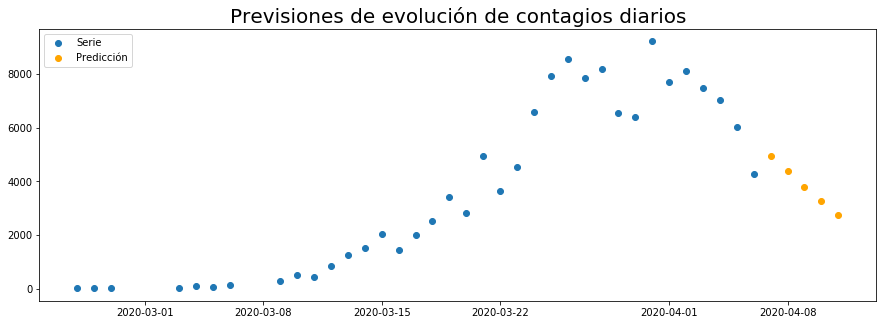

In [43]:
plt.figure(figsize = (15,5))

plt.title('Previsiones de evolución de contagios diarios', size = 20)

plt.plot(contagios.index, contagios['DIFER'], 'o', label = 'Serie')

plt.plot(index, arr_contagios_diarios_pred_2, 'o', color = 'orange',  label = 'Predicción')
plt.legend(loc = 2);

**CONTAGIOS (contagiados totales)**

In [46]:
print('ESTIMACIÓN CONTAGIADOS TOTALES: \n\n', arr_contagios_pred_2, '\n\n')

ESTIMACIÓN CONTAGIADOS TOTALES: 

                 PRED
2020-04-07  139994.0
2020-04-08  144369.0
2020-04-09  148171.0
2020-04-10  151427.0
2020-04-11  154175.0 




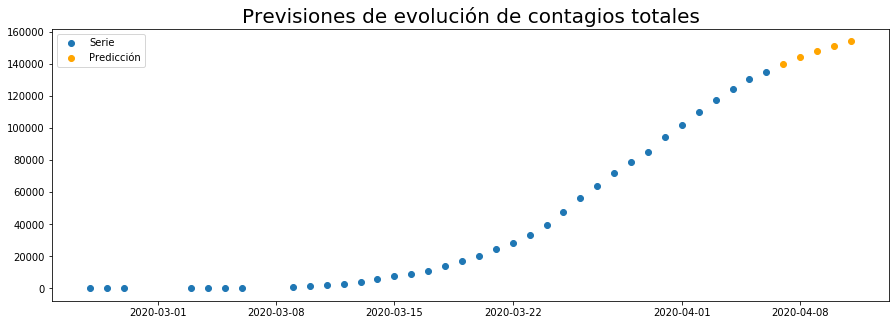

In [47]:
plt.figure(figsize = (15,5))

plt.title('Previsiones de evolución de contagios totales', size = 20)

plt.plot(contagios.index, contagios['CONTAGIOS'], 'o', label = 'Serie')

plt.plot(index, arr_contagios_pred_2, 'o', color = 'orange', label = 'Predicción')
plt.legend(loc = 2);

**MUERTOS (muertos diarios)**

In [48]:
print('ESTIMACIÓN DEFUNCIONES DIARIAS: \n\n', arr_muertos_diarios_pred_2, '\n\n')

ESTIMACIÓN DEFUNCIONES DIARIAS: 

              PRED
2020-04-07  593.0
2020-04-08  519.0
2020-04-09  446.0
2020-04-10  375.0
2020-04-11  310.0 




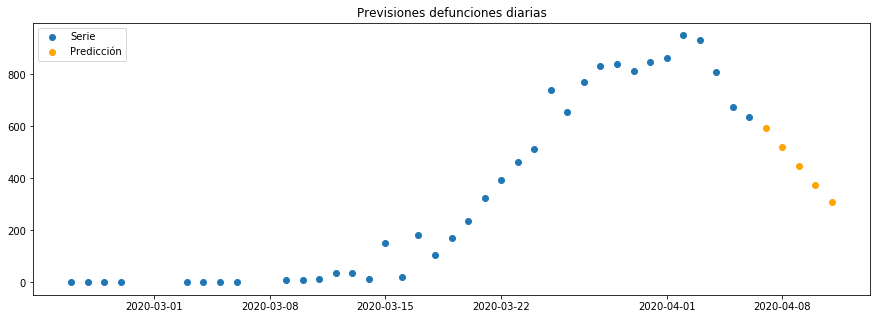

In [54]:
plt.figure(figsize = (15,5))

plt.title('Previsiones defunciones diarias')

plt.plot(muertos.index, muertos.loc[muertos.index, 'MUERTOS_DIARIOS'], 'o', label = 'Serie')

plt.plot(index, arr_muertos_diarios_pred_2, 'o', color = 'orange', label = 'Predicción')
plt.legend(loc = 2);

**MUERTOS (total defunciones)**

In [51]:
print('ESTIMACIÓN TOTAL DEFUNCIONES: \n\n', arr_muertos_pred_2, '\n\n')

ESTIMACIÓN TOTAL DEFUNCIONES: 

                PRED
2020-04-07  13648.0
2020-04-08  14167.0
2020-04-09  14613.0
2020-04-10  14988.0
2020-04-11  15298.0 




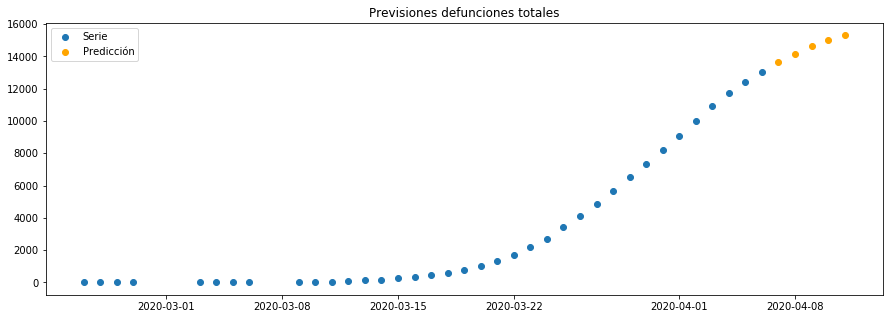

In [55]:
plt.figure(figsize = (15,5))

plt.title('Previsiones defunciones totales')

plt.plot(muertos.index, muertos.loc[muertos.index, 'MUERTOS'], 'o', label = 'Serie')

plt.plot(index, arr_muertos_pred_2, 'o', color = 'orange', label = 'Predicción')
plt.legend(loc = 2);